# Optimization of a polarization splitter 

In [11]:
import numpy as np # to create Matlab-like arrays
import matplotlib.pyplot as plt # to visualize results
from joblib import Parallel, delayed # to perform many optimizations in //

## The Fourier modal method 

We using a modal method for computing the transmission coefficient of different modes.

In [12]:
def cascade(T,U):
    '''Cascading of two scattering matrices T and U.
    Since T and U are scattering matrices, it is expected that they are square
    and have the same dimensions which are necessarily EVEN.
    '''

    n = int(T.shape[1] / 2)
    J = np.linalg.inv( np.eye(n) - np.matmul(U[0:n,0:n],T[n:2*n,n:2*n] ) )
    K = np.linalg.inv( np.eye(n) - np.matmul(T[n:2*n,n:2*n],U[0:n,0:n] ) )
    S = np.block([[T[0:n,0:n] + np.matmul(np.matmul(np.matmul(T[0:n,n:2*n],J),
    U[0:n,0:n]),T[n:2*n,0:n]),np.matmul(np.matmul(T[0:n,n:2*n],J),U[0:n,n:2*n])
    ],[np.matmul(np.matmul(U[n:2*n,0:n],K),T[n:2*n,0:n]),U[n:2*n,n:2*n]
    + np.matmul(np.matmul(np.matmul(U[n:2*n,0:n],K),T[n:2*n,n:2*n]),U[0:n,n:2*n])
    ]])
    return S

def c_bas(A,V,h):
    ''' Directly cascading any scattering matrix A (square and with even
    dimensions) with the scattering matrix of a layer of thickness h in which
    the wavevectors are given by V. Since the layer matrix is
    essentially empty, the cascading is much quicker if this is taken
    into account.
    '''
    n = int(A.shape[1]/2)
    D = np.diag(np.exp(1j*V*h))
    S = np.block([[A[0:n,0:n],np.matmul(A[0:n,n:2*n],D)],[np.matmul(D,A[n:2*n,0:n]),np.matmul(np.matmul(D,A[n:2*n,n:2*n]),D)]])
    return S

def marche(a,b,p,n,x):
    '''Computes the Fourier series for a piecewise function having the value
    a over a portion p of the period, starting at position x
    and the value b otherwise. The period is supposed to be equal to 1.
    Division by zero or very small values being not welcome, think about
    not taking round values for the period or for p. Then takes the toeplitz
    matrix generated using the Fourier series.
    '''
    from scipy.linalg import toeplitz
    l = np.empty(n,dtype = np.complex128)
    m = np.empty(n,dtype = np.complex128)
    tmp = 1 / (2 * np.pi * np.arange(1,n)) * (np.exp(-2 * 1j * np.pi * p * np.arange(1,n)) - 1) * np.exp(-2 * 1j * np.pi * 
    np.arange(1,n) * x)
    l[1:n] = 1j * (a - b) * tmp
    l[0] = p * a + (1 - p) * b
    m[0] = l[0]
    m[1:n] = 1j * (b - a) * np.conj(tmp)
    T = toeplitz(l,m)
    return T

def reseau(k0,a0,pol,e1,e2,n,blocs):
    '''Warning: blocs is a vector with N lines and 2 columns. Each
    line refers to a block of material e2 inside a matrix of material e1,
    giving its size relatively to the period (first column) and its starting
    position. #not anymore
    Warning : There is nothing checking that the blocks don't overlapp.
    '''
    n_blocs = blocs.shape[0];
    nmod = int(n/2)
    M1 = marche(e2,e1,blocs[0,0],n,blocs[0,1])
    M2 = marche(1/e2,1/e1,blocs[0,0],n,blocs[0,1])
    if n_blocs>1:
        for k in range(1,n_blocs):
            M1 = M1+marche(e2-e1,0,blocs[k,0],n,blocs[k,1])
            M2 = M2+marche(1/e2-1/e1,0,blocs[k,0],n,blocs[k,1])
    alpha = np.diag(a0 + 2 * np.pi * np.arange(-nmod,nmod+1)) + 0j
    if (pol==0):
        M = alpha * alpha - k0 * k0 * M1
        L,E = np.linalg.eig(M)
        L = np.sqrt(-L+0j)
        L = (1 - 2 * (np.imag(L)<-1e-15)) * L
        P = np.block([[E],[np.matmul(E,np.diag(L))]])
    else:
        T = np.linalg.inv(M2)
        M = np.matmul(np.matmul(np.matmul(T,alpha),np.linalg.inv(M1)),alpha)-k0*k0*T
        L,E = np.linalg.eig(M)
        L = np.sqrt(-L+0j)
        L = (1-2*(np.imag(L)<-1e-15))*L
        P = np.block([[E],[np.matmul(np.matmul(M2,E),np.diag(L))]])
    return P,L

def homogene(k0,a0,pol,epsilon,n):
    '''Generates the P matrix and the wavevectors exactly as for a
    periodic layer, just for an homogeneous layer. The results are
    analytic in that case.
    '''
    nmod = int(n/2)
    valp = np.sqrt(epsilon*k0*k0-(a0+2*np.pi*np.arange(-nmod,nmod+1))**2+0j)
    valp = valp*(1-2*(valp<0))*(pol/epsilon+(1-pol))
    P = np.block([[np.eye(n)],[np.diag(valp)]])
    return P,valp

def interface(P,Q):
    '''Computation of the scattering matrix of an interface, P and Q being the
    matrices given for each layer by homogene, reseau or creneau.
    '''
    n = int(P.shape[1])
    S = np.matmul(np.linalg.inv(np.block([[P[0:n,0:n],-Q[0:n,0:n]],[P[n:2*n,0:n],Q[n:2*n,0:n]]])),np.block([[-P[0:n,0:n],Q[0:n,0:n]],[P[n:2*n,0:n],Q[n:2*n,0:n]]]))
    return S



## The cost function 
The cost function represents de mean of the transmission coefficient of each first modes in the two polarization. 

In [13]:
def polarization_splitter(structure, wavelength):
    '''
    structure is a (NL, 2NC+1) matrix with NL number of layers and NC number of blocs in each layers. 
    Each value in the structure is a position, in a period, where the material is changed, except for the first value of each vectors 
    corresponding to thicknesses of the layers. 
    '''

    #wavelength = 600 # wavelength in nanometers
    period = 600 * 1.4142135623730951 # period of the grating
    eps_1 = 1 # permittivity of the first material, air
    eps_2 = 1.46**2 # permittivity of the second material, silicon 

    wavelength_norm = wavelength / period # wavelength
    wave_vector = 2 * np.pi / wavelength_norm # normalization of the wavelength

    nmod = 25 
    n = 2 * nmod + 1 # total number of modes computed in each layers

    n_layers = structure.shape[0] # number of layers in the structure
    n_cubes = int(structure.shape[1]/2) # number of blocs in each layers

    widths = np.empty((n_layers,n_cubes)) # 1D array of the widths of each blocs
    positions = np.empty((n_layers,n_cubes)) # 1D array of the positions in the period of the left-part of each bloc

    # the data in structure represents the positions where the material is changed in a layer. We transform thoses positions into two 
    # 1D arrays, one contains the widths and the second the positions of the silicon blocs.
    for i in range (0,n_layers):
        for j in range(0,n_cubes):
            positions[i,j] = structure[i,2*j+1]
            widths[i,j] = structure[i,2*j+2] - structure[i,2*j+1]

    # the structures of each layer are stored in the first column of the structure matrix. We stored them in a 1D array.
    thicknesses = structure[:,0] / period 

    # Normalization
    widths = widths / period
    positions = positions / period

    pol = 0 # we first compute the modes in TE (s) polarization

    # We initialize the S matrix 
    S = np.block([[np.zeros([n,n]),np.eye(n,dtype=np.complex128)],[np.eye(n),np.zeros([n,n])]])

    # We compute the eigenmodes and eigenvalues in the incident medium of permittivity eps_1
    P,V = homogene(wave_vector,0,pol,eps_1,n)

    # we then compute the eigenmodes and eigenvalues in each of the layers of the structure
    for i_layer in range(0,n_layers):

        # we recupere the data in the adapted format for using the reseau() function
        cubes = np.empty((n_cubes,2))
        cubes[:,0] = widths[i_layer]
        cubes[:,1] = positions[i_layer]
        
        # we compute the eigenmodes and eigenvalues in the 'i_layer' layer 
        Pc,Vc = reseau(wave_vector,0,pol,eps_1,eps_2,n,cubes)

        # We cascade the upper layer with the lower layer   
        S = cascade(S,interface(P,Pc))
        S = c_bas(S,Vc,thicknesses[i_layer])

        # we store the values in differents data
        P = Pc # eigenvectors
        V = Vc # eigenvalues

    # We compute the modes in the substrate of permittivity eps_2
    Pc,Vc = homogene(wave_vector,0,pol,eps_2,n)

    # TODO : I don't know why we are doing this : the substrate is eps_1 or eps_2 ?
    S=cascade(S,interface(P,Pc))
    P,V=homogene(wave_vector,0,pol,eps_1,n)

    # We store in a 1D array the amplitude of the 0th and the first orders of diffraction of the grating, 
    # in polarization TE 
    Te=np.empty(3,dtype = np.float64)
    for j in range(-1,2):
        Te[j+1] = abs(S[j + nmod,n + nmod]) ** 2 * np.real(V[j+nmod]) / (1.46 * wave_vector)

    # We did all the calcul again, with TM (p) polarization
    pol = 1

    # to save the data 
    S = np.block([[np.zeros([n,n]),np.eye(n,dtype=np.complex128)],[np.eye(n),np.zeros([n,n])]])
    
    # Incident medium computation
    P,V = homogene(wave_vector,0,pol,eps_1,n)

    # Computation in each layers
    for i_layer in range(0,n_layers):
        # format of the datas
        cubes = np.empty((n_cubes,2))
        cubes[:,0] = widths[i_layer]
        cubes[:,1] = positions[i_layer]

        # computation of the modes  
        Pc,Vc = reseau(wave_vector,0,pol,eps_1,eps_2,n,cubes)
        S=cascade(S,interface(P,Pc))
        S=c_bas(S,Vc,thicknesses[i_layer])
        P=Pc
        V=Vc

    # Computation in the substrate
    # TODO : same remarks as above, why so many steps in the computing ?
    Pc,Vc = homogene(wave_vector,0,pol,eps_2,n) # here and above, 0 stands for a normal angle of incidence (in degree)
    S = cascade(S,interface(P,Pc))
    P,V = homogene(wave_vector,0,pol,eps_1,n)
    
    # Save the important data
    Tm = np.empty(3,dtype = np.float64)
    for j in range(-1,2):
        Tm[j+1] = abs(S[j + nmod,n + nmod]) ** 2 * np.real(V[j + nmod]) * 1.46 / wave_vector

    # We maximize the transmission coefficient of the TE mode in the -1 order, and the transmission coefficient of the TM mode in the 
    # +1 order
    cost = 1 - (Te[0] + Tm[2]) / 2 
    
    return cost, Te, Tm

Ici il faut blablater sur le fonctionnement de DE : population qui évolue. 

In [14]:
def DE(budget,Npop,Nlayers,Nblocs,limits,period,Nopt):
    # Number of times the population is totally changed 
    Ngen = int(budget / Npop) 

    # Ponderations weights of mutation
    F1 = 0.9
    F2 = 0.8

    # Initialization
    cf = np.empty(Npop) # to store cost function value of all the structures in a population
    conv = np.empty(Ngen) # to store minimal cost function after each stage of an optimization
    Nparam = 2 * Nblocs + 1 # number of parameters to optimize

    # we need to initialize a population of structure in a good format

    # we first define the positions of the blocs
    arr = np.random.rand(Npop,Nlayers,Nparam)
    arr[:,:,1:Nparam] = np.sort(arr[:,:,1:Nparam])
    arr[:,:,1:Nparam] = limits[0]+(limits[1]-limits[0])*arr[:,:,1:Nparam]

    # We then define the thicknesses of the layers
    arr[:,:,0] = limits[2] + (limits[3]-limits[2])*arr[:,:,0]
    
    # We want a distance of 30 nm between each new positions in a layer
    esp = 30
    for j in range(Npop):
        for nl in range(Nlayers):
            k = 0
            for i in range(1,Nparam-1):
                if arr[j,nl,i+1]<(arr[j,nl,i] + esp):
                    k += 1
                    arr[j,nl,i+1] += k*esp

    # We compute the cost function of each structures in the initial population
    for l in range(Npop):
        cf[l], te, tm = polarization_splitter(arr[l], 600)

    # For each g in the nbumber of generations (total reconstitution of a population)
    for g in range(Ngen):

        # For each parent p in the population 
        for p in range(Npop):

            # We randomly choose three structures
            index = np.random.randint(Npop,size=(3))
            a = arr[index[0]]
            b = arr[index[1]]
            c = arr[index[2]]

            # We identify the best structure (it has the lower cost function value)
            best = arr[np.argmin(cf)]

            # We create a mutant structure
            y = c + F1 * (a-b) + F2 * (best-c)

            # We set the crossover factor between the mutant and the parent structures
            cr = 0.8 # we maximize the mutation
            ii = np.random.rand(Nlayers,Nblocs+1)

            # we set the child structure
            z = np.empty((Nlayers, Nparam))

            # for each layers
            for nl in range(Nlayers):
                index = 0
                # the thicknesses of the layers came from the parent of the mutant depending on the crossover factor
                z[nl,0] = (ii[nl,Nblocs]<=cr)*y[nl,0] + (ii[nl,Nblocs]>cr)*arr[p,nl,0]

                # for each positions parameters in a layer
                for nc in np.arange(1,Nparam,2):
                    # the positions of the layers came from the parent of the mutant depending on the crossover factor
                    z[nl,nc] = (ii[nl,index]<=cr)*y[nl,nc]+(ii[nl,index]>cr)*arr[p,nl,nc]
                    z[nl,nc+1] = (ii[nl,index]<=cr)*y[nl,nc+1]+(ii[nl,index]>cr)*arr[p,nl,nc+1]
                    index += 1

            # in each layers we assure the thicknesses are in the optimization domain
            for nl in range(Nlayers):
                cond_min_thick = z[nl,0] < limits[2]
                cond_max_thick = z[nl,0] > limits[3]
                z[nl,0] = (cond_min_thick==cond_max_thick)*z[nl,0]+cond_min_thick*arr[p,nl,0]+cond_max_thick*arr[p,nl,0]
                
                # for each parameters in the layers we assure the positions are in the optimization domain, too
                for idx in range(1,Nparam):
                    cond_min = z[nl,idx] < limits[0]
                    cond_max = z[nl,idx] > limits[1]
                    z[nl,idx] = (cond_min==cond_max)*z[nl,idx]+cond_min*arr[p,nl,idx]+cond_max*arr[p,nl,idx]
            
            # We assure that the positions are ranged
            z[:,1:Nparam] = np.sort(z[:,1:Nparam])

            # We assure that minimum 30 nm separate the blocs in a layer
            for nl in range(Nlayers):
                k = 0
                for i in range(1,Nparam-1):
                    if z[nl,i+1]<(z[nl,i] + esp):
                        k += 1
                        z[nl,i+1] += k * esp
            
            # we compute the cost function value of the child structure
            cfz, te, tm = polarization_splitter(z, 600)
            
            # the child replace the parent only if its cost function is lower
            if cfz<cf[p]:
                arr[p] = z
                cf[p] = cfz

        # we store the value of the minimal cost function afetr 1 generation 
        conv[g] = np.min(cf)
    
    # we identify and store the best structure optimized
    best = arr[np.argmin(cf)]

    # we save the data on a file.npz
    np.savez("polarization_splitter.npz", conv = conv, best = best)

    # we return the best structure optimized and the convergence of the optimization to check the success
    return(conv,best)

In [20]:
# the budget of the optimization should be sufficient to obtain a good convergence of the cost function
budget = 10000 

# The number of parents in a population 
Npop = 30

# period of the grating (we want order of diffractions here)
period = 600*1.4142135623730951

# minimal position for a change of material in a layer
pos_min = 30

# minimal and maximal thicknesses of a layer (in nanometers)
thick_min = 30
thick_max = 1400

# number of blocs in a layer
NC = 4

# maximal position for a change of material in a layer
pos_max = thick_min * NC * 2

# parametrization of the lower and upper values of each of the optimized parameters
limits = np.array([pos_min,pos_max, thick_min,thick_max])

# number of layers in the structure
NL = 3

# number of optimization (1 is sufficient to set up the budget, but many (50-100) are needed to check the success of the optimization)
Nopt = 1
conv,best = DE(budget, Npop, NL, NC, limits, period,Nopt)



# If you want to compute many optimizations in parallel, this below line have to be uncomment
#Parallel(n_jobs=10)(delayed(DE)(budget, Npop, NL, NC, limits, period,Nopt) for Nopt in range(50))

KeyboardInterrupt: 

In [16]:
# eventually we charge the data 
# data = np.load("polarization_splitter.npz")
# best = data['best']
# conv = data['conv']

[[ 978.60836049   34.90640814   88.38878091  122.72713287  217.32138505
   313.63912601  343.87585185  375.57615383  408.92837684]
 [1045.63814176  201.11215201  233.90492127  293.46606141  327.85791567
   413.18975685  490.86284845  557.74178791  621.50384542]
 [1075.79129332   40.62694479   92.52557642  153.03890966  263.1029415
   323.28004788  410.47624701  474.39535594  535.24202919]]


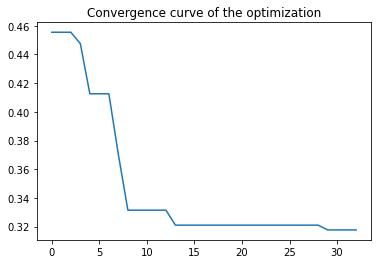

In [17]:
print(best)

plt.figure(1)
plt.plot(conv)
plt.title("Convergence curve of the optimization")
plt.show()

On trace le spectre de transmission de la meilleure structure optimisée

In [18]:
wavelengths = np.linspace(400,800,200)

TE_m1 = np.empty(wavelengths.size)
TE_p1 = np.empty(wavelengths.size)
TE_0 = np.empty(wavelengths.size)
TM_m1 = np.empty(wavelengths.size)
TM_p1 = np.empty(wavelengths.size)
TM_0 = np.empty(wavelengths.size)

for k in range(wavelengths.size):
    print(k)
    cost, Te, Tm = polarization_splitter(best, wavelengths[k])
    TE_m1[k] = Te[0]
    TE_p1[k] = Te[2]
    TE_0[k] = Te[1]
    TM_m1[k] = Tm[0]
    TM_p1[k] = Tm[2]
    TM_0[k] = Tm[1]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199


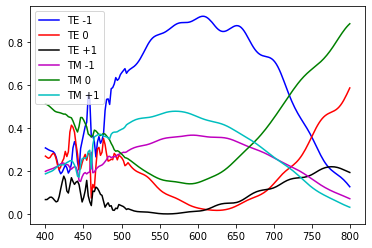

In [19]:
plt.figure(2)
plt.plot(wavelengths, TE_m1, "b", label = "TE -1")
plt.plot(wavelengths, TE_0, "r", label = "TE 0")
plt.plot(wavelengths, TE_p1, "k", label = "TE +1")
plt.plot(wavelengths, TM_m1, "m", label = "TM -1")
plt.plot(wavelengths, TM_0, "g", label = "TM 0")
plt.plot(wavelengths, TM_p1, "c", label = "TM +1")
plt.legend()
plt.show()